# Group -48
## P Anurag Reddy - 19CS30032
## Shashank Suroju - 19CS10061

# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import combinations # To create combinations from a given list
from sklearn.model_selection import train_test_split # To split training data into training and testing sets
from sklearn.metrics import accuracy_score # To measure accuracy of the model
import random # To get random numbers
from matplotlib import pyplot as plt # To draw plots

In [2]:
#names of all the columns in the dataset
columns = ['Age','Sex','Chest Pain Type','Resting BP','Serum Cholestoral',
           'Fasting Blood Sugar','Resting ECG Results','Max Heart Rate',
           'Exe Induced Angina','Oldpeak','Slope of the peak exercise ST segment',
           'No of major vessels colored by flourosopy','thal','Y']

In [4]:
#reading data into a pandas dataframe
data = pd.read_csv('heart.dat',sep=' ',header=None,names=columns)

In [5]:
#printing the first five columns of the dataset
data.head()

,Age,Sex,Chest Pain Type,Resting BP,Serum Cholestoral,Fasting Blood Sugar,Resting ECG Results,Max Heart Rate,Exe Induced Angina,Oldpeak,Slope of the peak exercise ST segment,No of major vessels colored by flourosopy,thal,Y
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [6]:
#index of columns with real feature values
cont_feat = [0,3,4,7,9]

# Question 1

In [7]:
#class node to define the structure of each node
class Node():
    def __init__(self, feature_index=None, threshold=None, dataset=None , left=None, right=None, parent=None, info_gain=None, value=None, status = 0):
        ''' constructor for the node class ''' 
        
        # for decision node
        self.feature_index = feature_index #the index of feature based on which we are splitting at this node
        self.threshold = threshold #the threshold with respect to which we are splitting
        self.dataset = dataset #the dataset which is to be used for splitting a given node
        self.left = left #left-child of the node
        self.right = right #right-child of the node
        self.parent = parent #parent of the node
        self.info_gain = info_gain #amount of information gained by split at this node
        self.status = status # variable to keep track if the node was checked during pruning
        
        # for leaf node
        self.value = value # classification of the leaf node

In [8]:
# class decision tree to make the classifier
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2, mode="gini"):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        self.mode = mode
        self.depth = 0
        self.nodes = 1
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth       
    
    def get_root(self):
        '''Returns the root node of the tree when called'''
        return self.root
    
    def get_depth(self):
        '''Returns the depth of the tree when called'''
        return self.depth
    
    def get_num_nodes(self):
        '''Returns the number of the nodes in the tree when called '''
        return self.nodes
    
    def entropy(self, y):
        ''' Computes the entroy of a particualr node '''
        
        cls_lbls = np.unique(y) # Getting different classes from Y
        enpy = 0 
        for cls in cls_lbls:
            prob_cls = len(y[y == cls]) / len(y) # calculating the probability of a class
            enpy += -prob_cls * np.log2(prob_cls) # calculating entropy
        return enpy
    
    def gini_index(self, y):
        ''' Computes the gini index of a particualr node '''
        
        cls_lbls = np.unique(y) # Getting different classes from Y
        gini = 0
        for cls in cls_lbls:
            prob_cls = len(y[y == cls]) / len(y) # calculating the probability of a class
            gini += prob_cls**2 # calculating gini index
        return(1 - gini)
        
    def information_gain(self, pnt, lt_cld, rt_cld, mode="enpy"):
        ''' Given parent node, children nodes and the mode of impurity measurement calculates the information gain'''
        
        wt_l = len(lt_cld) / len(pnt) # calculating the weight of left child
        wt_r = len(rt_cld) / len(pnt) # calculating the weight of right child
        if mode=="gini":
            inf_gain = self.gini_index(pnt) - (wt_l*self.gini_index(lt_cld) + wt_r*self.gini_index(rt_cld))
        else:
            inf_gain = self.entropy(pnt) - (wt_l*self.entropy(lt_cld) + wt_r*self.entropy(rt_cld))
        return inf_gain
    
    def get_best_split(self, d_set, num_smpls, num_ftrs):
        ''' Given the dataset, number  of samples and number of features at a node
            splits the dataset into left and right dataset based on a attribute and threshold computed'''
        
        bst_splt = {} # dictionary to store the best split
        max_inf_gain = -float("inf") # Initialising to a least value
        
        # loop over all the features
        for ftr_idx in range(num_ftrs): # looping over all feature indices
            ftr_vals = d_set[:, ftr_idx] # extracting all the rows of a feature index
            poss_thres = np.unique(ftr_vals) # extracting set of unique values from feature values
            if ftr_idx in cont_feat: # if feature has real feature values
                for thres in poss_thres:# loop over all the possible threshold values 
                    d_set_lft, d_set_rt = self.split(d_set, ftr_idx, thres) # getting a split using the current threshold value and current feature index
                    if len(d_set_lft)>0 and len(d_set_rt)>0: # checking if children are not empty
                        y, lft_y, rt_y = d_set[:, -1], d_set_lft[:, -1], d_set_rt[:, -1] # extracting the target values from all the data sets
                        curr_inf_gain = self.information_gain(y, lft_y, rt_y, self.mode) # computing information gain from all the target values extracted
                        if curr_inf_gain>max_inf_gain: # if current info gain is greater than max info gain then update best split 
                            bst_splt["feature_index"] = ftr_idx
                            bst_splt["threshold"] = thres
                            bst_splt["dataset_left"] = d_set_lft
                            bst_splt["dataset_right"] = d_set_rt
                            bst_splt["info_gain"] = curr_inf_gain
                            max_inf_gain = curr_inf_gain
            else: # if feature has nominal values
                vals = list(poss_thres) # list of all possible nominal values
                n = len(vals) # size of the list
                combs = [] # list to store all possible combinations of feature values
                for i in range(1,n//2+1):
                    comb = combinations(vals, i)
                    for j in list(comb):
                        cpy = vals.copy()
                        temp = []
                        temp.append(j)
                        for ele in j:
                            cpy.remove(ele)
                        temp.append(tuple(cpy))
                        combs.append(temp)
                # combinations are in the form of list of list of two tupples, the two tupples is the division of feature values into two sets
                for thres in combs:# loop over all the possible threshold values 
                    d_set_lft, d_set_rt = self.split(d_set, ftr_idx, thres) # getting a split using the current threshold value and current feature index
                    if len(d_set_lft)>0 and len(d_set_rt)>0: # checking if children are not empty
                        y, lft_y, rt_y = d_set[:, -1], d_set_lft[:, -1], d_set_rt[:, -1] # extracting the target values from all the data sets
                        curr_inf_gain = self.information_gain(y, lft_y, rt_y, self.mode) # computing information gain from all the target values extracted
                        if curr_inf_gain>max_inf_gain: # if current info gain is greater than max info gain then update best split 
                            bst_splt["feature_index"] = ftr_idx
                            bst_splt["threshold"] = thres
                            bst_splt["dataset_left"] = d_set_lft
                            bst_splt["dataset_right"] = d_set_rt
                            bst_splt["info_gain"] = curr_inf_gain
                            max_inf_gain = curr_inf_gain
        # return best split
        return bst_splt
    
    def split(self, d_set, ftr_idx, thres):
        ''' Splits the data into left and right subsets based on threshold and feature index'''
        if isinstance(thres,list): # checking if threshold is a list thereby checking if feature values are nominal or real
            d_set_lft = np.array([row for row in d_set if row[ftr_idx] in thres[0]])
            d_set_rt = np.array([row for row in d_set if row[ftr_idx] in thres[1]])
        else:
            d_set_lft = np.array([row for row in d_set if row[ftr_idx]<=thres])
            d_set_rt = np.array([row for row in d_set if row[ftr_idx]>thres])
        return d_set_lft, d_set_rt
    
    def build_tree(self, d_set, curr_depth=0):
        ''' Builds the tree recursively until the stopping conditions are met ''' 
        
        X, Y = d_set[:,:-1], d_set[:,-1] # dividing the dataset into features and target value
        num_smpl, num_ftr = np.shape(X) # extracting the number of samples and number of features from X
        
        # split until stopping conditions are met
        if num_smpl>=self.min_samples_split and curr_depth<self.max_depth:
            
            bst_splt = self.get_best_split(d_set, num_smpl, num_ftr)# finding the best split
            if bst_splt["info_gain"]>0: # checking if information gain of the node is positive
                lft_subtree = self.build_tree(bst_splt["dataset_left"], curr_depth+1) # recursively building left subtree
                self.nodes += 1 # adding 1 to the number of nodes
                rt_subtree = self.build_tree(bst_splt["dataset_right"], curr_depth+1) # recursively building right subtree
                self.nodes += 1 # adding 1 to the number of nodes
                return Node(bst_splt["feature_index"], bst_splt["threshold"], d_set ,lft_subtree, rt_subtree, None ,bst_splt["info_gain"]) # returning the decision node
                
        if curr_depth > self.depth: # updating the depth of the tree
            self.depth = curr_depth
        
        leaf_value = self.calculate_leaf_value(Y) # computing the classification of leaf node based on target values of the node
        return Node(value=leaf_value) # returning the leaf node
            
    def calculate_leaf_value(self, Y):
        ''' Computing the classification of leaf node based on target values of the node '''
        
        Y = list(Y) # converting from numpy array to list 
        return max(Y, key=Y.count) # returning the label with most count
    
    def print_tree(self, tree=None, indent="    ", count=1):
        ''' function to print the tree '''
        flag = 0             # Flag if current node is root
        if not tree:         # If tree is none then make it root of tree 
            print("Root")
            tree = self.root
            flag = 1

        if tree.value is not None:      # If current node is not leaf node the print the result
            if(int(tree.value) == 2):
                print(str(tree.value) + " Presence of heart disease")
            else:
                print(str(tree.value) + " Absence of heart disease")

        else:
            #self.print_details()
            var = columns[tree.feature_index]     # To store current attribute name
            var2 = (tree.info_gain)               # To store the information gain
            print("Attribute:" , var)             # printing Attribute
            if(flag == 1):                        # If current node is root
                print("Information gain:", var2)
                if isinstance(tree.threshold, list):    # checking the instance of threshold and printing the spliting rule
                    print("Spliting rule: If Attr =", tree.threshold[0], "then left, If Attr =",tree.threshold[1], "then right")
                else:
                    print("Spliting rule: If Attr <=", tree.threshold, "then left, else right")
            else:                                 # If it is not root node
                print((indent), "    Information gain:", var2)
                if isinstance(tree.threshold, list):   # checking the instance of threshold and printing the spliting rule
                    print((indent), "    Spliting rule: If Attr =", tree.threshold[0], "then left, If Attr =",tree.threshold[1], "then right")
                else:
                    print((indent), "    Spliting rule: If Attr <=", tree.threshold, "then left, else right")
            
            print("|-"+"-"*count + "-->left:",  end=" ")
            self.print_tree(tree.left, indent + "    ", count+4)       # recursively call left child of the node
            print("|-"+"-"*count + "-->right:",  end="")
            self.print_tree(tree.right, indent + "    ", count+4)      # recursively call right child of the node
    
    def fit(self, X, Y):
        ''' Calls build tree and stores the root node to root of tree '''
        
        d_set = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(d_set)
        self.point()
    
    def predict(self,X, root=None):
        ''' Calls make_prediction for every value of X which is the validation set '''
        if root == None:
            root = self.root
        preds = [self.make_prediction(x, root) for x in X]
        return preds
    
    def make_prediction(self, x, node):
        ''' Recursively traverses the tree to find the appropriate leaf node '''
        
        if node.value != None: # if it is a leaf node then return the classification
            return node.value
        
        ftr_val = x[node.feature_index] # getting the feature index of the node
        
        if isinstance(node.threshold,list): # checking if feature values are nominal or real
            if ftr_val in node.threshold[0]:
                return self.make_prediction(x, node.left) # traversing to left child 
            else:
                return self.make_prediction(x, node.right) # traversing to right child 
        else:
            if ftr_val<=node.threshold:
                return self.make_prediction(x, node.left) # traversing to left child 
            else:
                return self.make_prediction(x, node.right) # traversing to right child 
    
    def point(self, node=None):
        ''' Traverses the complete tree and points the children to their respective parents'''
        
        if node == None:
            node = self.root
            left = node.left
            right = node.right
            left.parent = node
            right.parent = node
            self.point(left)
            self.point(right)
        else:
            if(node.left != None):
                left = node.left
                left.parent = node
                self.point(left)
            if(node.right != None):
                right = node.right
                right.parent = node
                self.point(right)
        
        


In [9]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=391)

In [10]:
gini_classifier = DecisionTreeClassifier(max_depth=100, mode = "gini")
enpy_classifier = DecisionTreeClassifier(max_depth=100, mode = "enpy")
gini_classifier.fit(X_train,Y_train)
enpy_classifier.fit(X_train,Y_train)

In [11]:
gini_Y_pred = gini_classifier.predict(X_test) 
print(accuracy_score(Y_test, gini_Y_pred))

enpy_Y_pred = enpy_classifier.predict(X_test) 
print(accuracy_score(Y_test, enpy_Y_pred))

0.7222222222222222
0.6666666666666666


### Since the prediction accuracy of classifier using Gini Index as Impurity measure is more. We are building future classifiers in this assignment using Gini Index.

# Question 2

In [25]:
randomlist = random.sample(range(0,1000), 10)
gini_classifiers = []
gini_accu = []
gini_depths = []
gini_nodes = []
for i in range(10):
    gini_X_train, gini_X_test, gini_Y_train, gini_Y_test = train_test_split(X, Y, test_size=.2, random_state=randomlist[i])
    gini_classifier = DecisionTreeClassifier(max_depth=100, mode = "gini")
    gini_classifier.fit(gini_X_train,gini_Y_train)
    gini_classifiers.append(gini_classifier)
    gini_Y_pred = gini_classifier.predict(gini_X_test) 
    gini_accu.append(accuracy_score(gini_Y_test, gini_Y_pred))
    gini_depths.append(gini_classifier.get_depth())
    gini_nodes.append(gini_classifier.get_num_nodes())
    

In [26]:
print("Average Accuracy: ",sum(gini_accu)/len(gini_accu))

Average Accuracy:  0.7555555555555555


In [27]:
maxpos = gini_accu.index(max(gini_accu)) # Index of classifier with maximum accuracy

In [28]:
gini_accu

[0.7592592592592593,
 0.7407407407407407,
 0.7962962962962963,
 0.7592592592592593,
 0.6851851851851852,
 0.7777777777777778,
 0.7407407407407407,
 0.7407407407407407,
 0.7962962962962963,
 0.7592592592592593]

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=randomlist[maxpos])
classifier = DecisionTreeClassifier(max_depth=100, mode = "gini")
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print(acc)

0.7962962962962963


# Question 3

In [39]:
x = []
y = []
for depth in range(1,15): 
    gini_X_train, gini_X_test, gini_Y_train, gini_Y_test = train_test_split(X, Y, test_size=.2, random_state=randomlist[maxpos])
    gini_classifier = DecisionTreeClassifier(max_depth=depth, mode = "gini")
    gini_classifier.fit(gini_X_train,gini_Y_train)
    gini_Y_pred = gini_classifier.predict(gini_X_test)
    x.append(depth)
    y.append(accuracy_score(gini_Y_test, gini_Y_pred))

In [42]:
depth = y.index(max(y))+1
print(depth)

3


In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=randomlist[maxpos])
best_classifier = DecisionTreeClassifier(max_depth=depth, mode = "gini")
best_classifier.fit(X_train,Y_train)
Y_pred = best_classifier.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print(acc)

0.8703703703703703


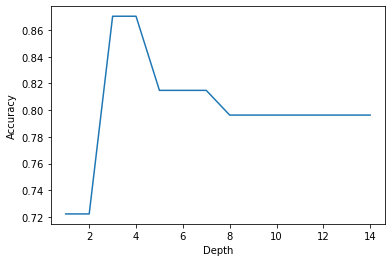

In [44]:
plt.plot(x,y)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

In [32]:
dct = {}
for i in range(10):
    dct[i] = gini_nodes[i]

dct = dict(sorted(dct.items(), key =lambda kv:(kv[1], kv[0])))
x = []
y = []
for k,v in dct.items() :
    x.append(v)
    y.append(gini_accu[k])


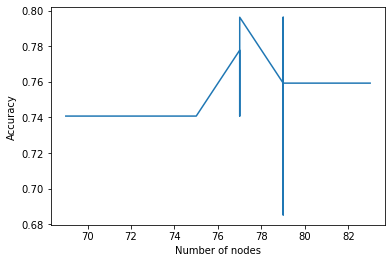

In [33]:
plt.plot(x,y)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()

# Question 4

In [34]:
root = classifier.get_root() # root of the classifier we are going to prune

In [35]:
def prune(node,trav,acc,classifier):
    
    if((trav == 'up') and (node == None)):# if we reached traversing from bottom up then exit 
        return
    else:# traversing downward until we reach leaf nodes
        if(trav == 'down'):
            left = node.left
            right = node.right
            if(left != None):
                if (left.value == None):
                    prune(left,'down',acc,classifier)
                else:
                    left.status = 1
                    prune(node,'up',acc,classifier)
            if(right != None):
                if (right.value == None):
                    prune(right,'down',acc,classifier)
                else:
                    right.status = 1
                    prune(node,'up',acc,classifier)
        elif(trav == 'up'): # pruning nodes while traversing upwards
            d_set = node.dataset
            Y = d_set[:,-1]
            node.value = classifier.calculate_leaf_value(Y) # making the decision node into a leaf node
            Y_pred = classifier.predict(X_test,root) # predicting the classification
            curr_acc = accuracy_score(Y_test, Y_pred) # calculating the accuracy of the prediction
            if(curr_acc > acc): # if new accuracy is greater then keep the decision node as leaf node
                acc = curr_acc
                classifier.nodes -= 2 # subtracting two nodes from the total number of nodes
            else: # converting back to decision node
                node.value = None
                
            prune(node.parent,'up',acc,classifier)

In [36]:
prune(root,'down',acc,classifier) # pruning the classifier

In [37]:
Y_pred = classifier.predict(X_test,root)
print(accuracy_score(Y_test, Y_pred))

0.9074074074074074


# Question 5

In [45]:
best_classifier.print_tree() # Printing the Best classifier obtained in question 3

Root
Attribute: Chest Pain Type
Information gain: 0.12949219768939335
Spliting rule: If Attr = (4.0,) then left, If Attr = (1.0, 2.0, 3.0) then right
|---->left: Attribute: No of major vessels colored by flourosopy
             Information gain: 0.08370835528681225
             Spliting rule: If Attr = (0.0,) then left, If Attr = (1.0, 2.0, 3.0) then right
|-------->left: Attribute: thal
                 Information gain: 0.16646610971644926
                 Spliting rule: If Attr = (7.0,) then left, If Attr = (3.0, 6.0) then right
|------------>left: 2.0 Presence of heart disease
|------------>right:1.0 Absence of heart disease
|-------->right:Attribute: Oldpeak
                 Information gain: 0.020952913752913777
                 Spliting rule: If Attr <= 0.2 then left, else right
|------------>left: 2.0 Presence of heart disease
|------------>right:2.0 Presence of heart disease
|---->right:Attribute: thal
             Information gain: 0.04586338950453961
             Spliting ru